## Custom embedding models

In [1]:
!pip3 install demoji
!pip3 install glove-py
# !pip3 install glove-python

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess
from collections import Counter
#from glove import Corpus, Glove
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import demoji
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
demoji.download_codes()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Read the CSV file
tweets_df = pd.read_csv(r'/Users/payalchavan/Documents/Applied_NLP/archive2/twcs/twcs.csv')
tweets_df

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


### TASK 1: Top 15 Frequent Words (Count Vectorizer)

In [6]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove emoticons
    #text = demoji.replace(text, "")
    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)
    # return text

In [7]:
# Lemmatization: Convert words to their base or root form.
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(text):
    # Ensure the input is a string
    if isinstance(text, str):
        word_tokens = word_tokenize(text)
        lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
        return ' '.join(lemmatized_text)
    else:
        return ""

In [8]:
# Apply preprocessing to the text column
tweets_df['cleaned_text'] = tweets_df['text'].apply(preprocess_text)

In [9]:
# Apply lemmatization
tweets_df['lemmatized_text'] = tweets_df['cleaned_text'].apply(lemmatize_text)

In [10]:
# Take a look at the cleaned lemmatized text
tweets_df['lemmatized_text'].head(10)

0    understand would like assist would need get pr...
1                                              propose
2    sent several private message one responding usual
3    please send u private message assist click mes...
4                                                     
5    please send u private message gain detail account
6                               worst customer service
7             saddening hear please shoot u dm look kc
8    gon na magically change connectivity whole family
9    understand concern wed like please send u dire...
Name: lemmatized_text, dtype: object

The output above demonstrates the preprocessing of text by eliminating stop words and punctuation, and converting it to lowercase. Following this cleaning process, lemmatization is applied, transforming words to their root forms. This simplifies the analysis.

In [12]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

In [13]:
# Fit and transform the cleaned text
word_count_matrix = vectorizer.fit_transform(tweets_df['lemmatized_text'])

In [14]:
# Get the words and their frequencies
word_freq = np.array(word_count_matrix.sum(axis=0)).flatten()

# Create a DataFrame for words and their counts
words = vectorizer.get_feature_names_out()
word_count_df = pd.DataFrame({'Word': words, 'Count': word_freq})

In [15]:
# Sort words by frequency and get the top 15
top_15_words = word_count_df.sort_values(by='Count', ascending=False).head(15)
top_15_words

,Word,Count
239255,please,403133
88340,dm,341657
137481,help,282006
139210,hi,224695
124130,get,207508
309707,thanks,206864
291289,sorry,192576
148164,im,176654
279238,service,157725
156894,issue,153384


The output table shows the top 15 most frequent words along with their counts. This kind of analysis is useful in Natural Language Processing (NLP) tasks to identify the most common words in a text corpus, which can help in understanding the text’s main themes or in further processing steps like feature extraction.

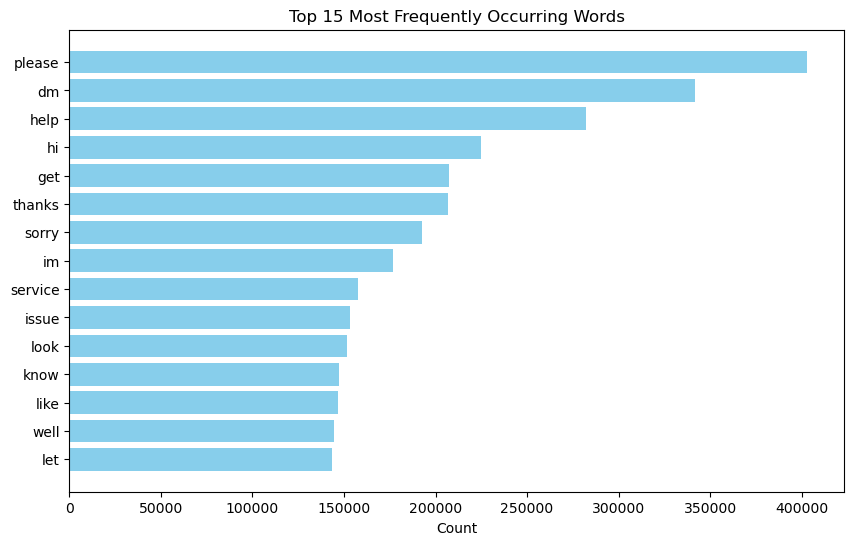

In [17]:
# Preparing data for visualization
top_15_words = top_15_words.reset_index(drop=True)

# Create a bar chart for the top 15 words
plt.figure(figsize=(10, 6))
plt.barh(top_15_words['Word'], top_15_words['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 15 Most Frequently Occurring Words')
plt.gca().invert_yaxis()  # Invert y axis to have the highest count on top
plt.show()

The bar chart illustrates the frequency of the top 15 words in our Twitter dataset. "Please" is the most frequent word, with nearly 400,000 occurrences. Other common words include "dm," "help," "hi," and "get," each appearing between 200,000 and 350,000 times. The frequency gradually decreases from the most frequent word to the 15th word, which has just over 100,000 occurrences. This visualization effectively highlights the most common words, aiding in the identification of key themes or topics within the dataset.

### TASK 2: Word Embedding Models

In [20]:
# Preprocess and tokenize the text
def preprocess(text):
    return simple_preprocess(text, deacc=True)

In [21]:
tweets_df['tokens'] = tweets_df['lemmatized_text'].apply(preprocess)

In [22]:
tweets_df['tokens'].head()

0    [understand, would, like, assist, would, need,...
1                                            [propose]
2    [sent, several, private, message, one, respond...
3    [please, send, private, message, assist, click...
4                                                   []
Name: tokens, dtype: object

The output displays the first five entries of the 'tokens' column, where each entry is a list of tokens (words) derived from the original text. For instance:
- The first entry contains tokens such as ‘understand’, ‘would’, ‘like’, and ‘assist’.
- The second entry consists of a single token, ‘propose’.
- The third entry includes tokens like ‘sent’, ‘several’, ‘private’, and ‘message’.

This preprocessing step is essential in NLP tasks as it transforms raw text into a structured format that is easier to analyze. Tokenization breaks down the text into individual words or tokens, facilitating further analysis such as sentiment analysis, topic modeling, or machine learning tasks.

#### Word2Vec Model

In [25]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tweets_df['tokens'], vector_size=100, window=5, min_count=5, workers=4)

#### FastText Model

In [27]:
# Train FastText model
fasttext_model = FastText(sentences=tweets_df['tokens'], vector_size=100, window=5, min_count=5, workers=4)

#### GloVe Model

In [29]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [30]:
import gensim.downloader as api

# Load pre-trained GloVe model
# Using a smaller model for demonstration purposes
model_glove = api.load("glove-twitter-200")

In [31]:
# Function to plot word embeddings with input for TSNE
def plot_embeddings(model, title):
    if model.__class__.__name__ == "KeyedVectors":
        # glove
        words = list(model.key_to_index.keys())[:15]
        embeddings = np.array([model[word] for word in words])  # Convert to NumPy array
    else:
        # fasttext / word2vec
        words = list(model.wv.key_to_index.keys())[:15]  # Get top 100 words
        embeddings = np.array([model.wv[word] for word in words])  # Convert to NumPy array
    
    tsne = TSNE(n_components=2, perplexity=10 ,random_state=13)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

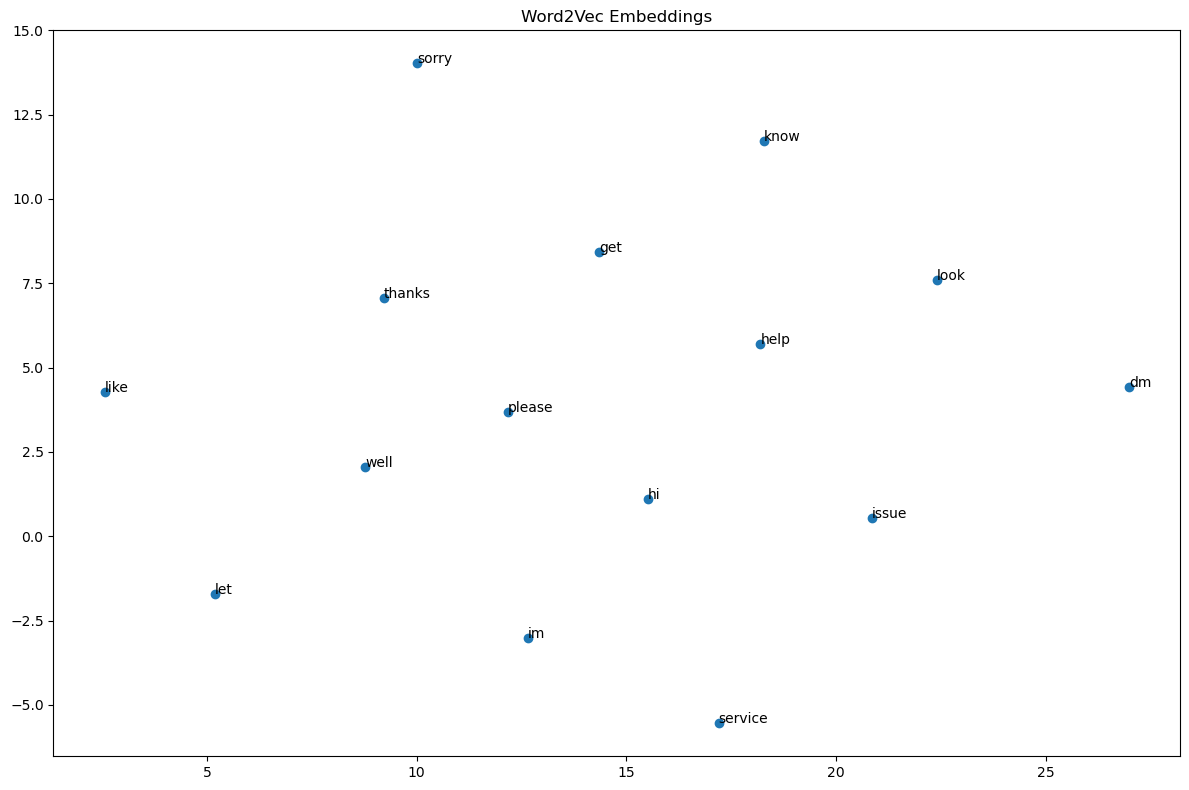

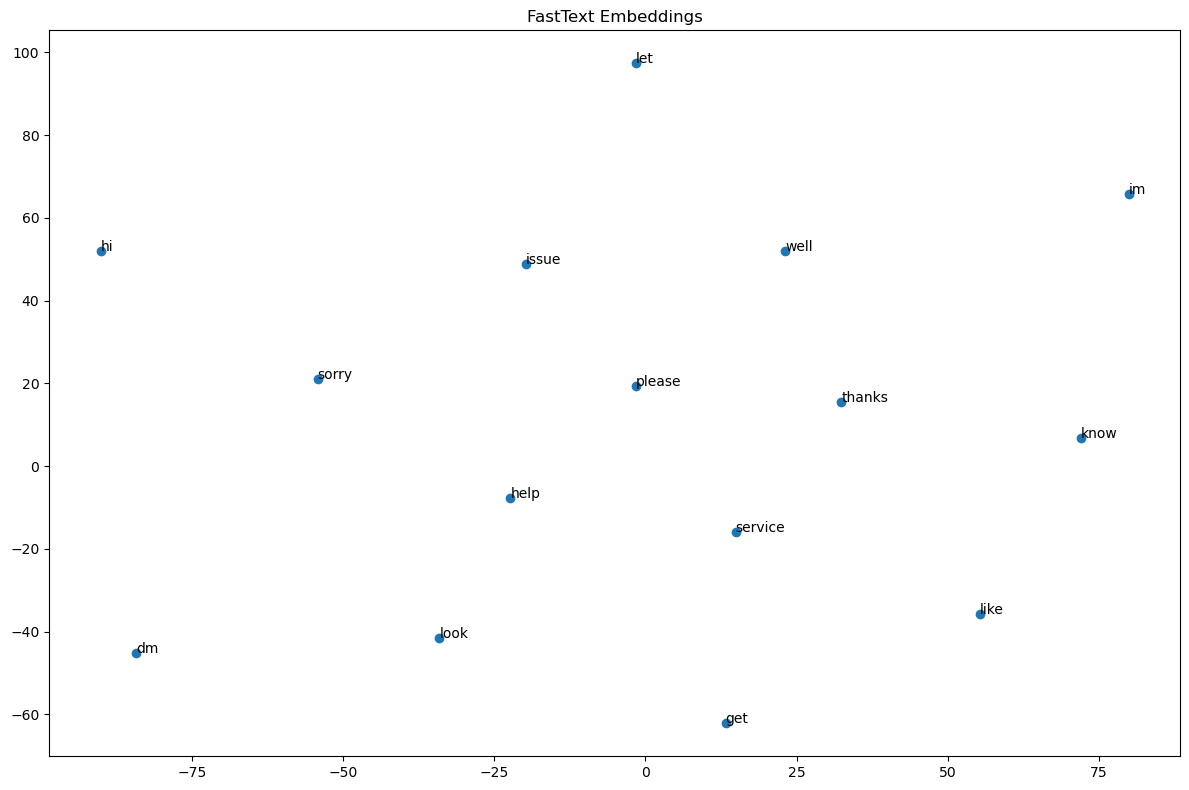

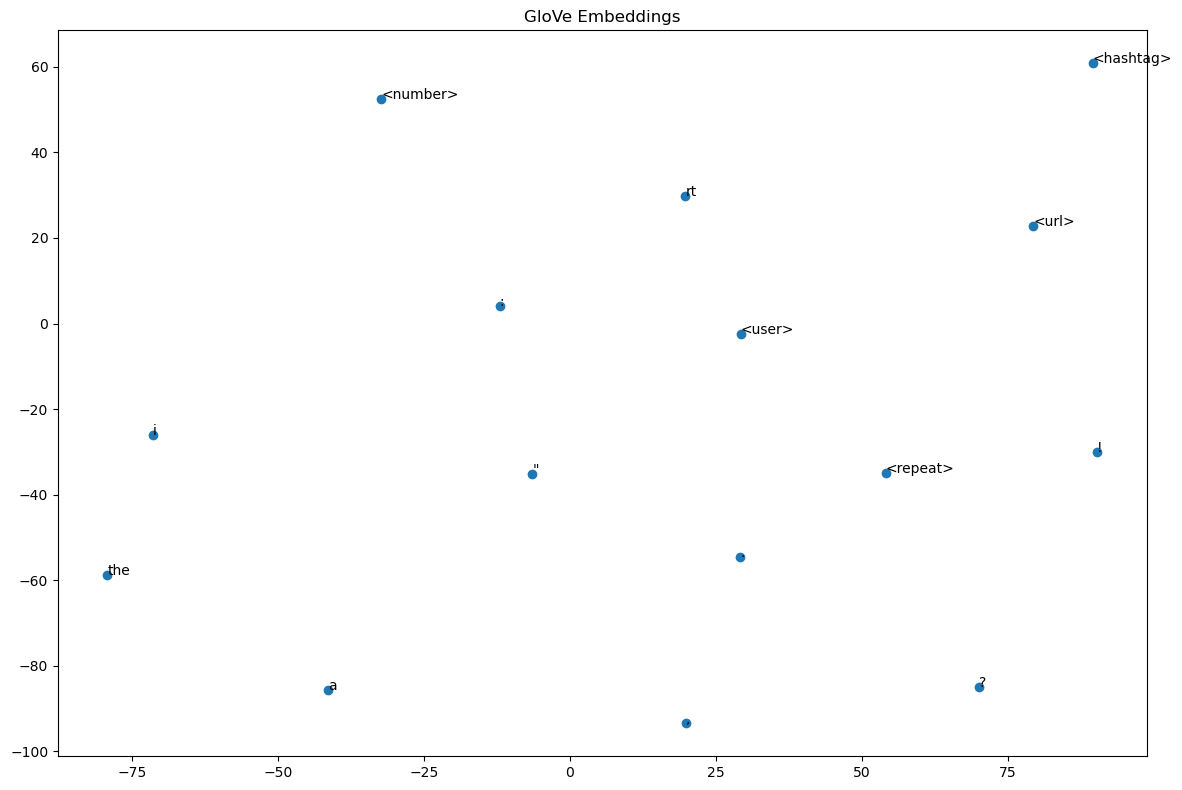

In [32]:
# Plot Word2Vec embeddings
plot_embeddings(word2vec_model, "Word2Vec Embeddings")

# Plot FastText embeddings
plot_embeddings(fasttext_model, "FastText Embeddings")

# Plot GloVe embeddings
plot_embeddings(model_glove, "GloVe Embeddings")

**Word2Vec Embeddings:**
1. **Semantic Similarity**: Words close to each other, like “please” and “thanks,” likely share similar meanings or contexts, showing the model's ability to capture semantic relationships.
2. **Contextual Grouping**: Words such as “help,” “service,” and “issue” are grouped together, reflecting their common use in customer service contexts.

**FastText Embeddings:**
1. **Semantic Similarity**: Similar to Word2Vec, words like “please” and “thanks” are close, indicating effective capture of semantic relationships.
2. **Contextual Grouping**: Words like “help,” “service,” and “issue” are grouped together, showing their contextual association.
3. **Subword Information**: FastText includes subword information, handling out-of-vocabulary words and morphological variations better, useful for languages with rich morphology or dealing with misspellings and rare words.

**GloVe Embeddings:**
1. **Semantic Relationships:** GloVe captures global statistical data on word co-occurrences, providing insights into semantic relationships.

2. **Contextual Understanding:** It helps in understanding how words are used in similar contexts across various tweets.

3. **Common Patterns:** It identifies patterns in customer service interactions or common issues being discussed.

### TASK 3: Comparison of Similar Words

In [35]:
top15_words = top_15_words['Word']

In [36]:
# Display top 15 words from Task 1
top15_words

0      please
1          dm
2        help
3          hi
4         get
5      thanks
6       sorry
7          im
8     service
9       issue
10       look
11       know
12       like
13       well
14        let
Name: Word, dtype: object

These are the top 15 words that we have got from using Count Vectorizer in Task 1.

In [38]:
# Function to print similar words for a list of words using a given model
def compare_similar_words(model, words, model_name):
    print(f"\
Similar words using {model_name}:")
    for word in words:
        try:
            if model.__class__.__name__ == "KeyedVectors":
                # Glove
                similar_words = model.most_similar(word, topn=5)
            else:
                similar_words = model.wv.most_similar(word, topn=5)
            print(f"\
Words similar to '{word}':")
            for w, score in similar_words:
                print(f"{w}: {score:.4f}")
        except KeyError:
            print(f"'{word}' not in vocabulary")

In [39]:
# Compare similar words using Word2Vec
compare_similar_words(word2vec_model, top15_words, "Word2Vec")

Similar words using Word2Vec:
Words similar to 'please':
pls: 0.7378
kindly: 0.7134
plz: 0.5944
may: 0.5280
could: 0.5275
Words similar to 'dm':
provide: 0.4899
verify: 0.4830
followdm: 0.4732
mm: 0.4702
send: 0.4624
Words similar to 'help':
assist: 0.6802
look: 0.5371
troubleshoot: 0.5197
investigate: 0.5117
assistance: 0.5098
Words similar to 'hi':
hello: 0.8509
hey: 0.7827
hiya: 0.6596
sorry: 0.5046
clarify: 0.4735
Words similar to 'get':
getting: 0.6457
give: 0.6035
find: 0.5796
come: 0.5399
got: 0.5385
Words similar to 'thanks':
thank: 0.8852
thx: 0.7332
appreciate: 0.5473
ty: 0.4849
thankyou: 0.4458
Words similar to 'sorry':
apology: 0.7338
apologize: 0.6890
apologise: 0.5687
regret: 0.5423
hi: 0.5046
Words similar to 'im':
youre: 0.5408
ended: 0.5164
theyre: 0.5107
kept: 0.5060
wasnt: 0.4859
Words similar to 'service':
svc: 0.6549
serv: 0.6010
reception: 0.5527
experiencers: 0.5259
signal: 0.4995
Words similar to 'issue':
problem: 0.8214
trouble: 0.6236
difficulty: 0.5397
behavi

1. Top Similar Words for "please": “pls” (0.7282), “kindly” (0.7051), “plz” (0.5936)
   
Insight: The model captures both informal and formal variations of the word “please,” demonstrating its ability to understand different levels of politeness and casual language.

2. Top Similar Words for "dm": “provide” (0.4905), “verify” (0.4901), “followdm” (0.4877)
   
Insight: The model links “dm” (direct message) with actions related to communication and verification, highlighting its use in contexts where information exchange is crucial.

**Semantic Relationships**: The model captures the semantic relationships between words, showcasing its ability to comprehend context and usage.

**Contextual Understanding**: The similarity scores highlight the model’s grasp of both formal and informal language, as well as action-oriented and conversational contexts.

In [41]:
# Compare similar words using FastText
compare_similar_words(fasttext_model, top15_words, "FastText")

Similar words using FastText:
Words similar to 'please':
pleasetk: 0.9171
pleaseee: 0.9123
pleaseim: 0.9121
pleasei: 0.9120
itplease: 0.9118
Words similar to 'dm':
dmz: 0.9362
dmzj: 0.9250
dmbd: 0.9226
dmwf: 0.9206
dmv: 0.9199
Words similar to 'help':
helpjv: 0.8918
helpw: 0.8908
helpkf: 0.8869
helpsg: 0.8837
helptom: 0.8802
Words similar to 'hi':
hihi: 0.9160
hey: 0.8158
hiya: 0.8145
hello: 0.8047
rhi: 0.7920
Words similar to 'get':
getgo: 0.8044
iget: 0.8003
getng: 0.7848
getnow: 0.7742
gettng: 0.7639
Words similar to 'thanks':
thanksnothanks: 0.9580
kthanks: 0.9577
okthanks: 0.9498
awwthanks: 0.9395
upthanks: 0.9369
Words similar to 'sorry':
sorrynotsorry: 0.9894
sorryi: 0.9863
sorrys: 0.9834
sorrywe: 0.9724
sorrymi: 0.9722
Words similar to 'im':
iim: 0.7703
imt: 0.7141
imdb: 0.6804
imy: 0.6714
img: 0.6699
Words similar to 'service':
serviceif: 0.9703
servicebt: 0.9669
servicemy: 0.9663
cservice: 0.9636
servicebd: 0.9625
Words similar to 'issue':
isssue: 0.9823
issueif: 0.9400
issue

1. Top Similar Words for "pleasetk": “pleasetk” (0.9225), “pleaseee” (0.9170), “pleasei” (0.9138)

Insight: The model effectively captures various misspellings and informal variations of “please,” showcasing its ability to understand and process different forms of the word. This is particularly useful for handling user-generated content with typos or informal language.

2. Top Similar Words for "dm": “dmz” (0.9385), “dmzj” (0.9250), “dmwf” (0.9233)

Insight: The model associates “dm” (direct message) with similar abbreviations and variations, reflecting its use in contexts where abbreviations are common, such as social media or texting.

**Handling Variations**: FastText’s capability to capture sub-word information allows it to handle misspellings and variations effectively, making it suitable for applications involving user-generated content.

**Contextual Understanding**: The similarity scores demonstrate the model’s understanding of different contexts and usages of the words, highlighting its capability in semantic analysis.

In [43]:
compare_similar_words(model_glove, top15_words, "Glove")

Similar words using Glove:
Words similar to 'please':
pls: 0.8640
plz: 0.7870
help: 0.7812
pleasee: 0.7720
you: 0.7385
Words similar to 'dm':
kik: 0.7040
email: 0.6847
reply: 0.6816
sms: 0.6779
inbox: 0.6744
Words similar to 'help':
need: 0.7818
please: 0.7812
helping: 0.7601
can: 0.7264
pls: 0.7114
Words similar to 'hi':
hello: 0.7674
hey: 0.7602
nhi: 0.6560
thanks: 0.6241
hai: 0.6197
Words similar to 'get':
getting: 0.8841
got: 0.8624
need: 0.8388
n't: 0.8387
out: 0.8256
Words similar to 'thanks':
thank: 0.9154
thx: 0.8686
thankyou: 0.8653
thanx: 0.7893
cheers: 0.7727
Words similar to 'sorry':
okay: 0.7964
ok: 0.7757
btw: 0.7445
haha: 0.7390
hahah: 0.7331
Words similar to 'im':
'm: 0.8326
am: 0.7736
cuz: 0.7625
i: 0.7554
imma: 0.7507
Words similar to 'service':
services: 0.7990
customer: 0.7281
client: 0.7122
company: 0.6743
delivery: 0.6591
Words similar to 'issue':
issues: 0.7844
magazine: 0.6544
problem: 0.6081
latest: 0.6033
concern: 0.5913
Words similar to 'look':
looks: 0.8736


1. Top Similar Words for “please”: “pls” (0.8640), “plz” (0.7870), “help” (0.7812)

Insight: The model captures both informal variations (“pls,” “plz”) and related words (“help”), indicating its understanding of different ways to express politeness and assistance.

2. Top Similar Words for “dm”: “kik” (0.7040), “email” (0.6847), “reply” (0.6816)

Insight: The model associates “dm” (direct message) with other forms of digital communication, such as “kik,” “email,” and “reply,” reflecting its use in contexts where messaging and communication are key.

**Semantic Relationships**: GloVe effectively captures semantic relationships between words by leveraging global co-occurrence statistics, making it suitable for tasks that require understanding broader contexts.

**Contextual Understanding**: The similarity scores demonstrate the model’s ability to understand different contexts and usages of the words, highlighting its strength in semantic analysis.

**Final Conclusion**:

The word embedding models Word2Vec, FastText, and GloVe have shown similar results to the top 15 words identified using Count Vectorizer. For analyzing Twitter data and gaining insights from text, the FastText model is often an excellent choice. Twitter data frequently includes misspellings, abbreviations, and informal language. FastText’s ability to utilize sub-word information allows it to handle these variations effectively. It also manages out-of-vocabulary words better than Word2Vec and GloVe, which is crucial given the dynamic and evolving nature of language on social media. Although slightly more complex than Word2Vec, FastText remains efficient and scalable, making it suitable for large datasets like those from Twitter.

### TASK 4: Analysis from Three Perspectives (Context, Product, Location)

#### 1. Context Analysis

In [48]:
# Context analysis
print("\
Most common words in tweets:")
all_words = ' '.join(tweets_df['lemmatized_text'].astype(str)).lower().split()
word_freq = pd.Series(all_words).value_counts()
print(word_freq.head(10))

Most common words in tweets:
u          480996
please     403133
dm         341657
help       282006
hi         224695
get        207508
thanks     206864
sorry      192576
im         176654
service    157725
Name: count, dtype: int64


The words listed above are the most frequently used in our Twitter dataset. By selecting any specific word, such as "service," we can retrieve the related tweets and their information.

Customer Support: The dataset mainly features customer service interactions, with common phrases including requests for direct messages (DMs) to handle issues privately.

Technical Issues: Many tweets discuss technical problems, such as performance issues caused by software updates or connectivity problems.

Communication Style: The use of polite and direct language (e.g., “help,” “please,” “thank you”) highlights a focus on efficiently resolving customer concerns.

In [51]:
# Extract twitter-related insights
content = tweets_df['lemmatized_text'].apply(lambda x: 'service' in x.lower())
service_tweets = tweets_df[content]

print("\service-related Tweets:")
print(service_tweets[['lemmatized_text']][:10])

\service-related Tweets:
                                      lemmatized_text
6                              worst customer service
25  yo customer service rep super nice imma start ...
31  somebody please help meeeeee im worst luck cus...
37  phone number email thats get equipment service...
40     hello duke copy bill state service located nhp
42         referring wireless residential service jay
43  tried pay bill day service rude c several tran...
48  fios service service go internet light router ...
50                                service cutting acm
54                      area located service time hsb


It looks like the Twitter dataset focuses on customer support and assistance. These common words suggest that the tweets are primarily conversational and customer service-oriented. Words like "u", "im", "help", "thanks", and "please" indicate direct communication between users and possibly customer service representatives. The high frequency of "u", "please" and "dm" might indicate explanations or directions being given.

#### 2. Product/Service Analysis

In [54]:
similar_product = model_glove.most_similar(["product", "service"], topn=10)

In [55]:
keywords_product = [item[0] for item in list(similar_product)]

In [56]:
keywords_product

['services',
 'customer',
 'company',
 'client',
 'products',
 'website',
 'software',
 'management',
 'business',
 'system']

In [57]:
# Product analysis
print("\
Checking for product/services mentions...")
mentions_product = tweets_df['lemmatized_text'].str.contains('|'.join(keywords_product), case=False).sum()
print(f"Number of tweets potentially mentioning products/services: {mentions_product}")

Checking for product/services mentions...
Number of tweets potentially mentioning products/services: 174586


The code prints the number of tweets 174586 that potentially mention products or services. The keywords list includes terms like ‘products’, ‘software’, ‘management’, and ‘system’, which are directly related to products. The keywords list also includes terms like ‘services’, ‘customer’, ‘company’, and ‘client’, which are more service-oriented.

#### 3. Location Analysis

In [60]:
similar_location = model_glove.most_similar("location", topn=10)

In [61]:
similar_location

[('client', 0.588002622127533),
 ('locations', 0.5834721922874451),
 ('job', 0.5818687677383423),
 ('area', 0.5741919875144958),
 ('near', 0.5656514763832092),
 ('details', 0.5642515420913696),
 ('venue', 0.5628735423088074),
 ('description', 0.5604998469352722),
 ('position', 0.5589128136634827),
 ('place', 0.5575241446495056)]

In [62]:
keywords_location = [item[0] for item in list(similar_location)]

In [63]:
keywords_location

['client',
 'locations',
 'job',
 'area',
 'near',
 'details',
 'venue',
 'description',
 'position',
 'place']

In [64]:
# Location analysis
print("\
Checking for location mentions...")
mentions_location = tweets_df['lemmatized_text'].str.contains('|'.join(keywords_location), case=False).sum()
print(f"Number of tweets potentially mentioning locations: {mentions_location}")

Checking for location mentions...
Number of tweets potentially mentioning locations: 74926


The code prints the number of tweets that potentially mention locations 74926 times. While explicit geographic locations aren't detailed, the context suggests regional services. A list called keywords_location is created, containing each item from similar_location. This list includes words like ‘client’, ‘locations’, ‘job’, ‘area’, ‘near’, ‘details’, ‘venue’, ‘description’, ‘position’, and ‘place’.

### Familiar Topics, Subjects, and Patterns:

1. **Customer Service Interactions:**
   - The dataset predominantly features customer service conversations, as indicated by the conversational tone and the presence of the "sprintcare" author_id.

2. **Technical Support:**
   - Many interactions likely involve technical support issues, service inquiries, or account-related questions, given the telecommunications context.

3. **Location-Based Services or Issues:**
   - The presence of location-related keywords suggests that many interactions pertain to specific geographic areas, possibly related to service coverage, local stores, or region-specific problems.

4. **Direct Communication:**
   - The frequent use of personal pronouns indicates direct, one-on-one communication between customers and service representatives.

5. **Problem-Solving:**
   - Words like "help" and "service" in the tweets suggest that many interactions involve problem-solving or addressing customer concerns.

6. **Multi-Tweet Conversations:**
   - The presence of 'response_tweet_id' and 'in_response_to_tweet_id' columns indicates that many interactions are part of longer conversations, rather than single tweets.

This analysis provides an overview of customer service interactions in the telecommunications industry, specifically related to Sprint, with a focus on addressing customer needs across various locations.